# High-frequency data and limit order book - Lab4
ZHANG Mian \
CentraleSupélec

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.stats
from scipy.optimize import minimize
import os
import Hawkes as hk
from statsmodels.distributions.empirical_distribution import ECDF

## 1. Implémentation des routines

In [5]:
def simulate_hawkes(alpha,beta,lambda_0,T):
    t = 0
    lstar = lambda_0
    events = []
    sum_nu = 0
    while t<T:
        u = np.random.random()
        t = t-np.log(u)/lstar
        lambda_t = lambda_0+np.exp(-beta*t)*sum_nu
        if t>=T:
            return events
        d = np.random.random()
        if d < lambda_t/lstar:
            lstar = lambda_t + alpha
            sum_nu += alpha*np.exp(beta*t)
            events += [t]
        else:
            lstar = lambda_t           

In [6]:
def compute_ll(alpha,beta,lambda_0,T,samples):
    ll = -lambda_0*T
    ti_minus = samples[0]
    for ti in samples:
        ll -= alpha/beta*(1-np.exp(-beta*(T-ti)))
        if ti_minus == samples[0]:
            R = 0
        else:
            R = (1+R)*np.exp(-beta*(ti-ti_minus))
        ll += np.log(lambda_0 + alpha*R)
        ti_minus = ti
    return ll 

In [7]:
def MLE_estimator(theta_0,T,samples):
    def obj(theta):
        return -compute_ll(theta[0],theta[1],theta[2],T,samples)
    bounds = [(0,None),(0,None),(0,None)]
    def fun(theta):
        return theta[1]/theta[0] - 1
    const = {"type": "ineq","fun": fun}
    return minimize(obj,theta_0,bounds = bounds, constraints = const, method = 'L-BFGS-B')["x"]

In [8]:
def duration_transform(alpha,beta,lambda_0,T,samples):
    new_samples = []
    A = 1
    for i in range(1,len(samples)):
        dt = samples[i]-samples[i-1]
        t = lambda_0*dt + alpha/beta*(1-1*np.exp(-beta*dt))*A
        new_samples += [t]
        A = 1 + np.exp(-beta*dt)*A
    return new_samples

## 2. Test de l'implémentation

In [9]:
alpha = 0.9
beta = 1.5
T = 100
lambda_0 = 2
samples = simulate_hawkes(alpha,beta,lambda_0,T)

In [10]:
theta_hat = MLE_estimator([0.1,0.5,1],T,samples)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:542: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  RuntimeWarning)


In [11]:
theta_hat

array([0.91264122, 1.84105389, 2.53290669])

On retrouve des valeurs proches de celles attendues pour tous les paramètres.

In [12]:
tt = duration_transform(theta_hat[0],theta_hat[1],theta_hat[2],T,samples)

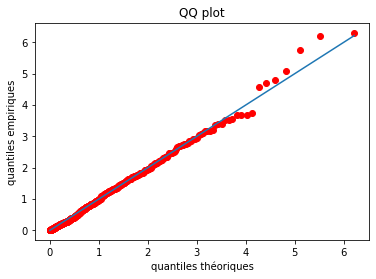

In [13]:
ecdf = ECDF(tt)
qnorm = []
for i in range(len(ecdf.y)):
    q = ecdf.y[i]
    qnorm += [scipy.stats.expon.ppf(q)]

fig,ax = plt.subplots()
ax.scatter(qnorm,ecdf.x, color = "red")
ax.plot(qnorm,qnorm)
ax.set_title("QQ plot")
ax.set_xlabel("quantiles théoriques")
ax.set_ylabel("quantiles empiriques");

On retrouve bien que les durations transformées sont distribuées selon une exponentielle de paramètre 1, ce qui indique un bon fit.

## 3. Convergence et performance

In [14]:
alpha = 0.9
beta = 1.5
lambda_0 = 2
theta_star = np.array([0.9,1,2])
tss = []
tes = []
covs = []
for T in range(50,200,10):
    print(T)
    ts = 0
    te = 0
    es = []
    for i in range(100):
        t = time.time()
        samples = simulate_hawkes(alpha,beta,lambda_0,T)
        ts += (time.time()-t)/100
        t = time.time()
        theta_hat = MLE_estimator([0.1,0.5,1],T,samples)
        te += (time.time()-t)/100
        es += [theta_star-theta_hat]
    covs += [np.linalg.det(np.cov(es,rowvar = False))]
    tss += [ts]
    tes += [te]  

50


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:542: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


60
70
80
90
100
110
120
130
140
150
160
170
180
190


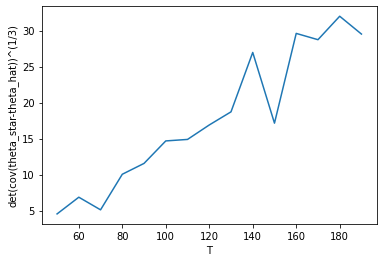

In [15]:
fig,ax = plt.subplots()
ax.plot([T for T in range(50,200,10)],1/np.array(covs)**(1/3))
ax.set_xlabel("T")
ax.set_ylabel("det(cov(theta_star-theta_hat))^(1/3)");

Comme on a 3 paramètres à estimer, on s'attend à ce que $\frac{1}{det(cov(\theta^*-\hat{\theta}_T))}$ soit linéaire en $T^{3}$, ce qui semble être le cas.

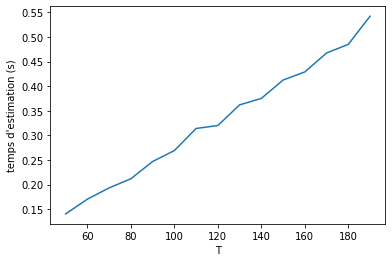

In [16]:
fig,ax = plt.subplots()
ax.plot([T for T in range(50,200,10)],tes)
ax.set_xlabel("T")
ax.set_ylabel("temps d'estimation (s)");

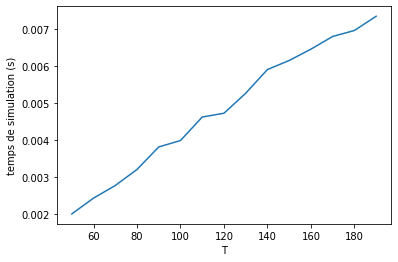

In [17]:
fig,ax = plt.subplots()
ax.plot([T for T in range(50,200,10)],tss)
ax.set_xlabel("T")
ax.set_ylabel("temps de simulation (s)");

Le temps d'estimation des paramètres semble linéaire en $T$, le temps de simulation semble linéaire également, mais n'a pas aussi bien convergé en 100 itérations.